# Generated Dissimilarity datasets

In [1]:
import os
os.environ['MEMORY_LIMIT'] = '16GB'
import seaborn as sns
import numpy as np
import scipy as scp
import matplotlib.pyplot as plt
import pandas as pd
from os.path import exists, join
from io import StringIO  
from datetime import timedelta

ALGORITHMS = {
    'structural': 'Structural',
    'structural-variant': 'Splitted Structural',
    'sed': 'Sed',
    'lblint': 'Lbl-Int',
    'bib': 'Binary branch',
    'sedindex': 'Sed Index',
    'lblindex': 'Lbl-Int Index',
    'structuralindex': 'Structural Index',
}

datasets = ('dblp', 'ptb', 'python', 'sentiment', 'swissprot', 'treefam')
ALGORITHMS_ENUM_NAMES = {
    'structural': 'Structural',
    'structural-variant': 'StructuralVariant',
    'sed': 'Sed',
    'lblint': 'Lblint',
    'bib': 'Bib'
}

In [2]:
bases = [f'base-{b}' for b in [25,100,200]]
datasets = [f'{base}/{x}' for x in ['lsmall', 'lbig'] for base in bases]

In [3]:
from os.path import join
def get_query_runtime_for_ds(basepath: str, ds: str):
    qt = join(basepath, ds, 'query_times.txt')
    # qt = f'resources/workloads/generated/{ds}/query_times.txt'
    with open(qt) as f:
        content = f.read()
    times = [l.split(':')[1].strip('ms') for i, l in enumerate(content.split('\n')) if i % 3 == 1]
    candidates = [l.split(':')[1] for i, l in enumerate(content.split('\n')) if i % 3 == 2]
    methods = [l for i, l in enumerate(content.split('\n')) if i % 3 == 0 and l]
    csv_content = ','.join(methods) + '\n' +','.join(times)  + '\n' + ','.join(candidates) + '\n'
    strio = StringIO(csv_content)
    df = pd.read_csv(strio)
    df.insert(0, 'Dataset', [ds] * 2)
    # df = df.set_index('Dataset')
    return df

In [4]:
def get_searching_part(basepath: str):
    df = pd.DataFrame()
    cdf = pd.DataFrame()
    stats_df = pd.DataFrame()
    for ds in datasets:
        tdf = get_query_runtime_for_ds(basepath, ds)
        df = pd.concat([df, tdf.iloc[[0]]])
        cdf = pd.concat([cdf, tdf.iloc[[1]]])
        stats = pd.read_csv(join(basepath, ds, 'collection.csv'))
        stats.insert(0, 'Dataset', [ds.capitalize()])
        stats_df = pd.concat([stats_df, stats])

    df = df.rename(columns={
        'Lblint index': ALGORITHMS['lblindex'],
        'Lblint': ALGORITHMS['lblint'],
        'Sed Index': ALGORITHMS['sedindex'],
        'Sed': ALGORITHMS['sed'],
        'Structural Index': ALGORITHMS['structuralindex'],
        'Structural': ALGORITHMS['structural'],
        })
    df = df.set_index('Dataset')
    cdf = cdf.set_index('Dataset')
    df['process_part'] = 'searching'

    return df, cdf, stats_df

In [5]:
# returns precision, verification times and selectivies
def get_precision_and_verification_for_ds(basepath: str, cdf: pd.DataFrame) -> (pd.DataFrame, pd.DataFrame, pd.DataFrame):
    # precision dataframe
    pdf = pd.DataFrame()
    # verification times dataframe
    vdf = pd.DataFrame()
    selectivites = dict()
    for ds in datasets:
        temp_df = pd.DataFrame.from_dict({ 'dataset': [ds] })
        tv_df = pd.DataFrame.from_dict({ 'Dataset': [ds] })
        times_ = []
        methods = ['Lbl-Int Index', 'Lbl-Int', 'Sed Index', 'Sed', 'Structural Index', 'Structural']
        for mtd in ('Lblint', 'Sed', 'Structural'):
            verification_path = join('resources/workloads/generated', ds, f'{mtd.lower()}-verified.txt')
            candidate_count = cdf[mtd][ds]
            
            with open(verification_path) as f:
                lines = f.read().split('\n')
            times = pd.Series([float(t) for t in lines if ',' not in t and t])
            correct_results = [l for l in lines if ',' in l and l]
            # candidate_count = 
            precision =  len(correct_results) / candidate_count
            # print(mtd, ds, candidate_count, len(correct_results))
            temp_df[mtd] = precision
            temp_df
    
            total_verification_time_ms = times.div(1_000_000).sum()
            # twice for index version
            times_.extend([total_verification_time_ms, total_verification_time_ms])
            # print(ds, mtd, precision)
        
        sdf = pd.read_csv(StringIO('\n'.join(correct_results)), names=['T1', 'T2'])
        sdf = sdf[sdf['T1'] != sdf['T2']].sort_values(by='T1')
        m = sdf.groupby('T1').count().mean(axis=0)
        selectivity = 100 * ((m.reset_index()[0][0]) / 1000)
        selectivites[ds] = {'Selectivity':  selectivity }
        pdf = pd.concat([pdf, temp_df])
        vdf = pd.concat([vdf, pd.DataFrame.from_dict({'Dataset': [ds] * 6, 'process_part': ['verification'] * 6, 'Method': methods, 'Time': times_, }) ])
        
    
    sdf = pd.DataFrame.from_dict(selectivites)
    pdf = pdf.set_index("dataset")
    vdf.sort_values(['Method', 'Dataset'], inplace=True)
    return pdf, vdf, sdf


In [6]:
def plot_selectivity(sdf):
    # plt.figure(figsize=(18, 12))
    bx = sns.barplot(sdf, width=0.6)
    # bx.tick_params(axis='x', rotation=45, rotation_mode='anchor'labelsize=10, ha='left')
    bx.set_xticklabels(bx.get_xticklabels(), 
                       rotation=45,     # Rotation angle
                       ha='right',      # Horizontal alignment: 'left', 'center', or 'right'
                       rotation_mode='anchor')  # Ensures alignment works with rotation
    
    # Add value annotations on top of each bar
    for i, ds in enumerate(datasets):
        v = sdf[ds]['Selectivity']
        bx.text(i, round(v, 2), str(round(v, 2)) + '%', 
                ha='center', va='bottom',  # horizontally centered, placed just above the bar
                fontweight='bold')
    return bx


In [7]:
def plot_precision(pdf):
    return sns.heatmap(pdf, annot=True)

In [8]:
from dataclasses import dataclass

In [9]:
@dataclass
class PlotData:
    pdf: pd.DataFrame
    vdf: pd.DataFrame
    sdf: pd.DataFrame
    plotdata: pd.DataFrame
    statistics: pd.DataFrame

In [10]:
def get_plot_data_ds(basepath: str) -> PlotData:
    df, cdf, statistics = get_searching_part(basepath)
    pdf, vdf, sdf = get_precision_and_verification_for_ds(basepath, cdf)
    
    
    df['Dataset'] = df.index
    ldf = df.melt(id_vars=["Dataset", "process_part"], var_name="Method", value_name="Time", value_vars=['Lbl-Int Index', 'Lbl-Int', 'Sed Index', 'Sed', 'Structural Index', 'Structural'])
    complete = pd.concat([ldf, vdf])
    plot_data = complete.pivot_table(
        index=['Dataset', 'Method'],
        columns='process_part',
        values='Time'
    ).reset_index()

    return PlotData(
        pdf = pdf,
        vdf = vdf,
        sdf = sdf,
        plotdata = plot_data,
        statistics = statistics,
    )

In [11]:
hue_color_palette = {'searching': sns.color_palette()[0], 'verification': sns.color_palette()[1]}

# 10 - 20 distinct labels per tree

In [12]:
data: PlotData = get_plot_data_ds('resources/workloads/generated-10-20')

In [13]:
display(data.statistics)

,Dataset,min_tree,max_tree,avg_tree,tree_count,avg_unique_labels_per_tree,avg_tree_distinct_labels,distinct_labels,Unnamed: 7
0,Base-25/lsmall,91,117,104.018,1000,0.150,28.450,2962,NaN
0,Base-100/lsmall,90,117,102.861,1000,0.123,26.851,2966,NaN
0,Base-200/lsmall,92,118,103.435,1000,0.109,25.285,2976,NaN
0,Base-25/lbig,92,117,104.248,1000,10.065,26.588,11660,NaN
0,Base-100/lbig,90,115,103.194,1000,9.208,26.189,11687,NaN
0,Base-200/lbig,91,117,102.511,1000,8.103,25.637,11880,NaN


In [14]:
alldf = pd.melt(data.plotdata, id_vars=['Dataset', 'Method'], value_vars=['searching', 'verification'], value_name="time")
alldf[['BaseSize', 'LabelSize']] = alldf['Dataset'].str.split('/', expand=True)
alldf[['Base', 'BaseSize']] = alldf['BaseSize'].str.split('-', expand=True)
alldf.drop('Base', axis=1, inplace=True)
alldf['BaseSize'] = alldf['BaseSize'].astype(int)

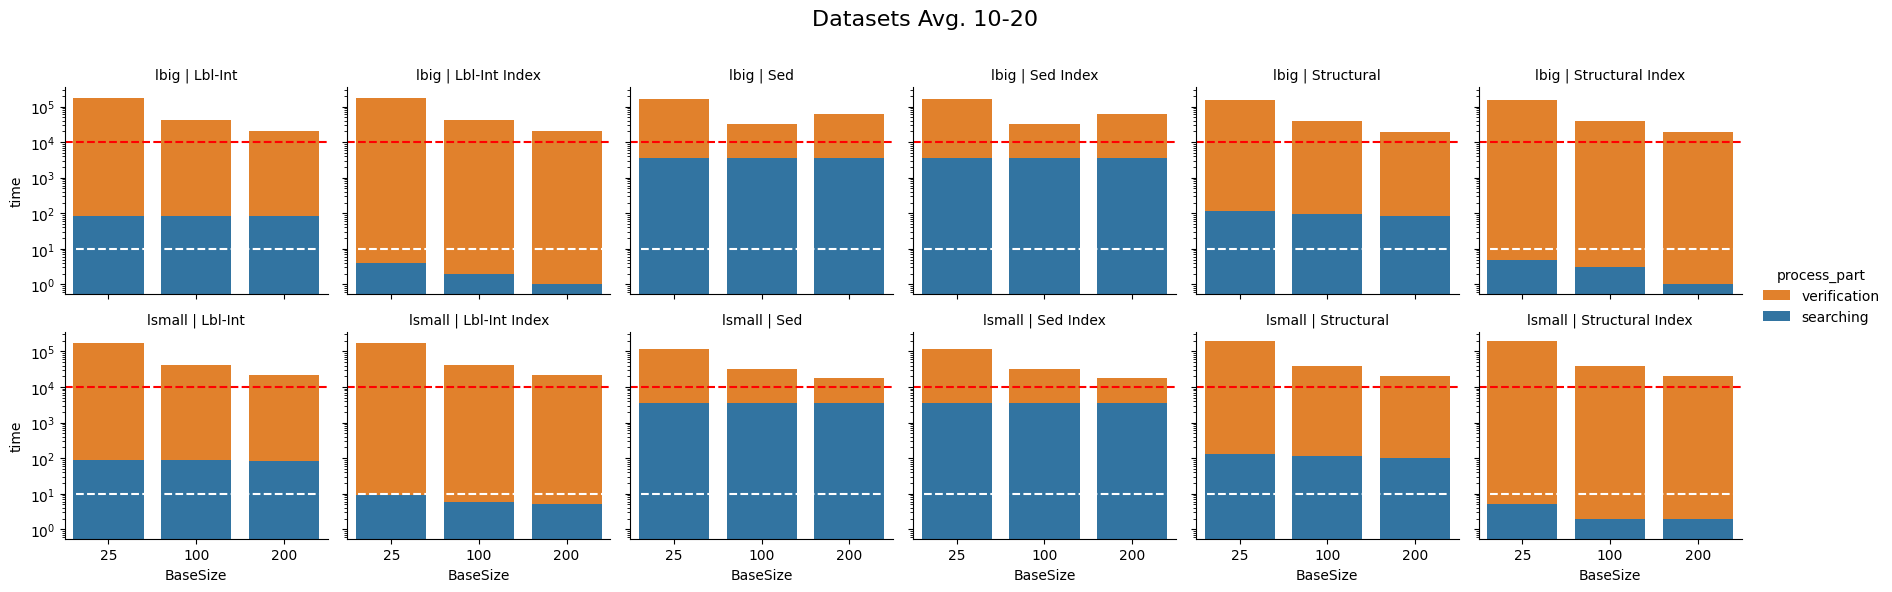

In [15]:
g = sns.FacetGrid(
    alldf.sort_values('process_part', ascending=False).sort_values('Method'),
    col = 'Method',
    row = 'LabelSize',
    hue = 'process_part',
    palette = hue_color_palette,
    )
g = (g.map(sns.barplot, 'BaseSize', 'time', errorbar = None, order=['25', '100', '200']).add_legend())

g.set(yscale='log')

# Increase font size for titles, labels, and ticks
g.set_titles('{row_name} | {col_name}')   # Increase font size of titles
# g.set_axis_labels('Base Size', 'Value', fontsize=28)  # Axis labels font size
axes = g.axes.flatten()
for ax in axes:
    ax.axhline(y=10_000, color='r', linestyle='--')
    ax.axhline(y=10, color='white', linestyle='--')

# Set the super title
g.fig.suptitle("Datasets Avg. 10-20", fontsize=16)

# Adjust layout to make space for the super title
g.fig.subplots_adjust(top=0.85)  # Adjust this value as needed


# plt.suptitle('Times for 30-50 datasets')
# g.fig.subplots_adjust(hspace=0.2, wspace=0.35)
plt.show()
g.savefig("Facet.png")

/tmp/ipykernel_36754/540418489.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(order, rotation=45, ha="right")  # Rotate labels by 45 degrees
/tmp/ipykernel_36754/540418489.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(order, rotation=45, ha="right")  # Rotate labels by 45 degrees
/tmp/ipykernel_36754/540418489.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(order, rotation=45, ha="right")  # Rotate labels by 45 degrees
/tmp/ipykernel_36754/540418489.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(order, rotation=45, ha="right")  # Rotate labels by 45 degrees


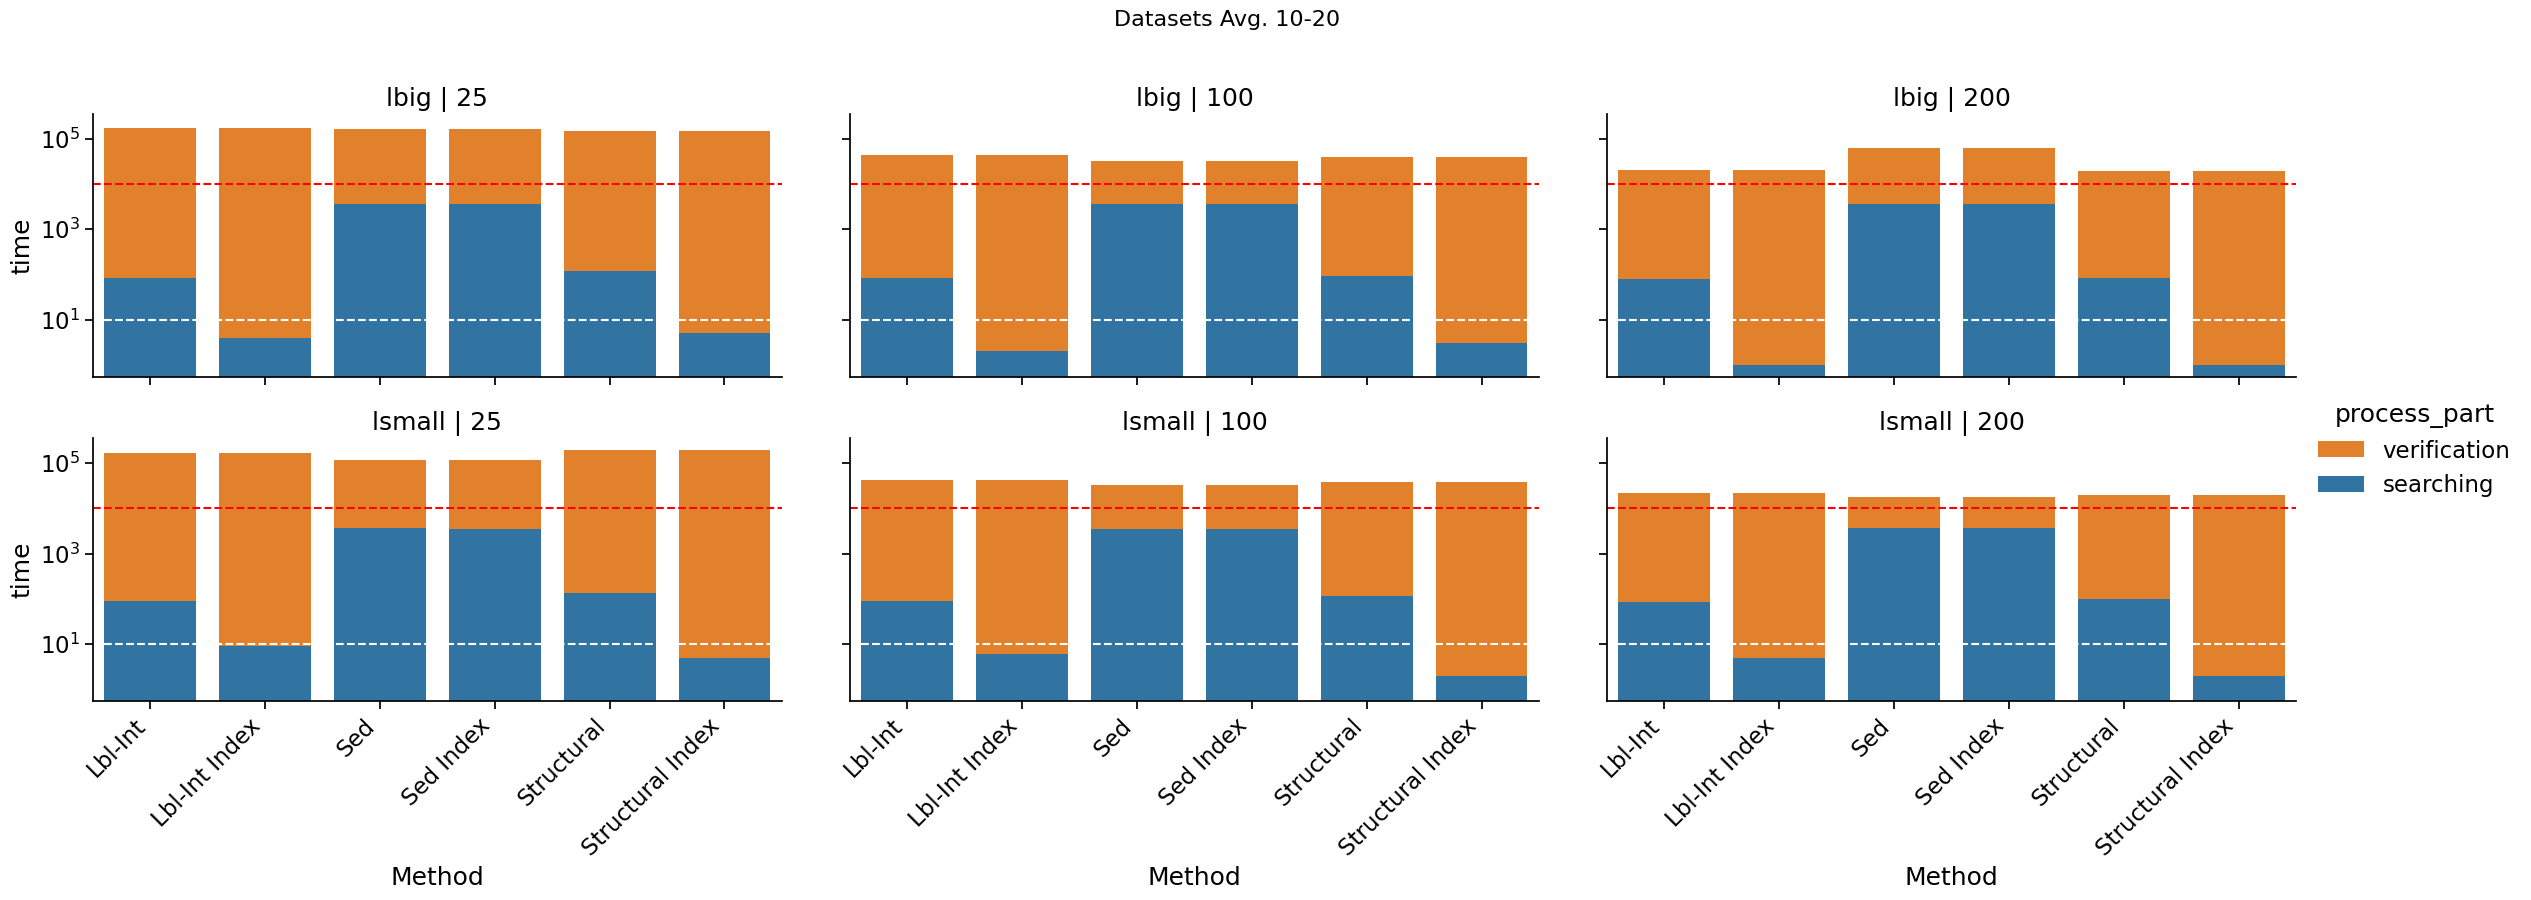

In [16]:
order = ['Lbl-Int', 'Lbl-Int Index', 'Sed', 'Sed Index', 'Structural', 'Structural Index']
# Increase overall font size
sns.set_context("notebook", font_scale=1.5)
g = sns.FacetGrid(
    alldf.sort_values('process_part', ascending=False).sort_values('Method'),
    col = 'BaseSize',
    row = 'LabelSize',
    hue = 'process_part',
    palette = hue_color_palette,
    height=4, aspect=2
    )
g = (g.map(sns.barplot, 'Method', 'time', errorbar = None, order=order).add_legend())

g.set(yscale='log')

# Increase font size for titles, labels, and ticks
g.set_titles('{row_name} | {col_name}')   # Increase font size of titles
# g.set_axis_labels('Base Size', 'Value', fontsize=28)  # Axis labels font size
axes = g.axes.flatten()
for ax in axes:
    ax.axhline(y=10_000, color='r', linestyle='--')
    ax.axhline(y=10, color='white', linestyle='--')

# Set the super title
g.fig.suptitle("Datasets Avg. 10-20", fontsize=16)

# Adjust layout to make space for the super title
g.fig.subplots_adjust(top=0.85)  # Adjust this value as needed
# Rotate x-tick labels
for ax in g.axes.flat:
    ax.set_xticklabels(order, rotation=45, ha="right")  # Rotate labels by 45 degrees


# plt.suptitle('Times for 30-50 datasets')
# g.fig.subplots_adjust(hspace=0.2, wspace=0.35)
plt.show()
sns.set_context("notebook", font_scale=1)

# Distinct labels 30-50 per tree

In [17]:
data: PlotData = get_plot_data_ds('resources/workloads/generated-30-50')

In [18]:
display(data.statistics)

,Dataset,min_tree,max_tree,avg_tree,tree_count,avg_unique_labels_per_tree,avg_tree_distinct_labels,distinct_labels,Unnamed: 7
0,Base-25/lsmall,92,119,102.578,1000,0.111,48.460,2971,NaN
0,Base-100/lsmall,89,117,103.662,1000,0.061,47.926,2981,NaN
0,Base-200/lsmall,90,117,102.842,1000,0.028,46.003,2995,NaN
0,Base-25/lbig,89,116,104.327,1000,9.755,48.506,11927,NaN
0,Base-100/lbig,90,117,103.449,1000,9.034,48.572,13628,NaN
0,Base-200/lbig,90,118,103.426,1000,7.352,46.401,14918,NaN


In [19]:
alldf = pd.melt(data.plotdata, id_vars=['Dataset', 'Method'], value_vars=['searching', 'verification'], value_name="time")
alldf[['BaseSize', 'LabelSize']] = alldf['Dataset'].str.split('/', expand=True)
alldf[['Base', 'BaseSize']] = alldf['BaseSize'].str.split('-', expand=True)
alldf.drop('Base', axis=1, inplace=True)
alldf['BaseSize'] = alldf['BaseSize'].astype(int)

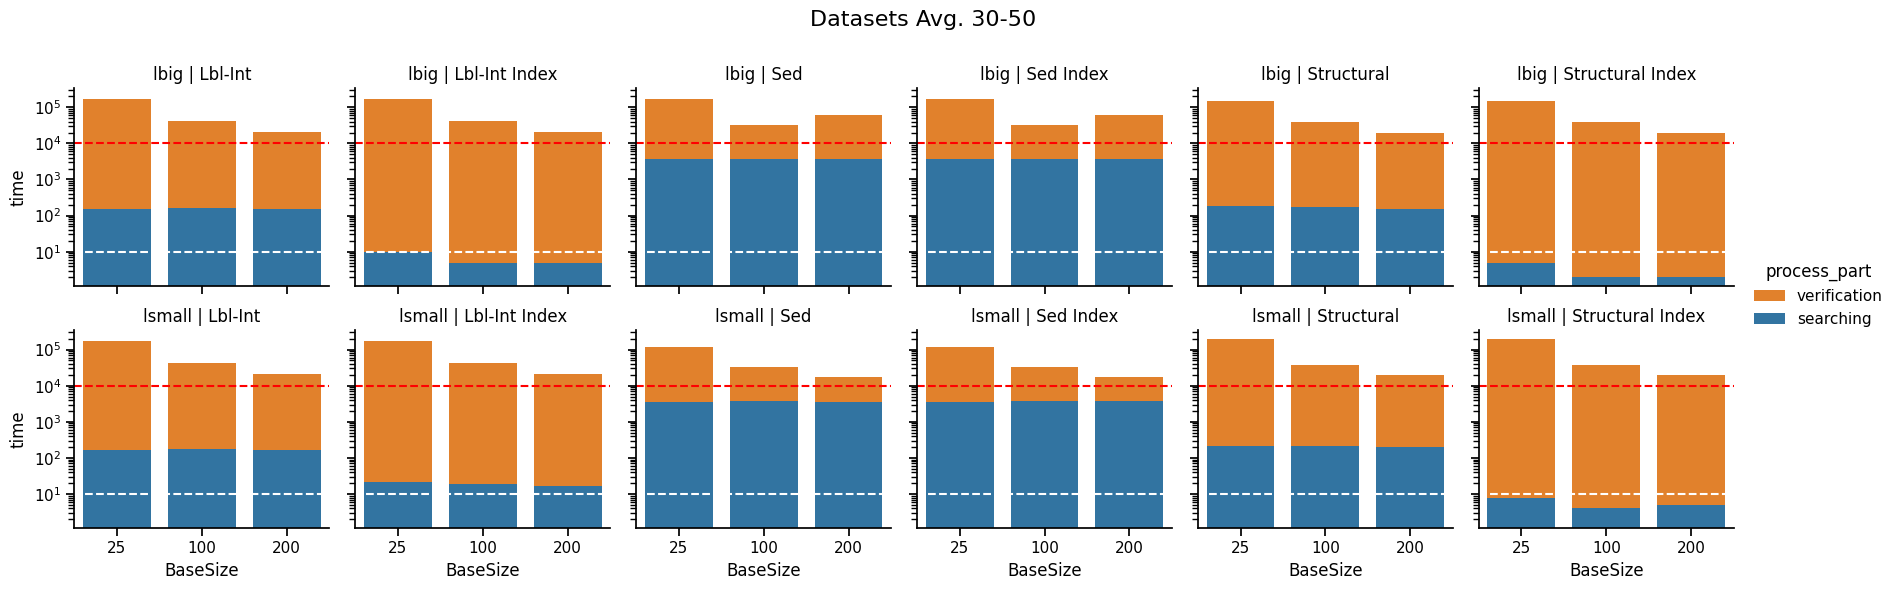

In [20]:
g = sns.FacetGrid(
    alldf.sort_values('process_part', ascending=False).sort_values('Method'),
    col = 'Method',
    row = 'LabelSize',
    hue = 'process_part',
    palette = hue_color_palette,
    )
g = (g.map(sns.barplot, 'BaseSize', 'time', errorbar = None, order=['25', '100', '200']).add_legend())

g.set(yscale='log')

# Increase font size for titles, labels, and ticks
g.set_titles('{row_name} | {col_name}')   # Increase font size of titles
# g.set_axis_labels('Base Size', 'Value', fontsize=28)  # Axis labels font size
axes = g.axes.flatten()
for ax in axes:
    ax.axhline(y=10_000, color='r', linestyle='--')
    ax.axhline(y=10, color='white', linestyle='--')

# Set the super title
g.fig.suptitle("Datasets Avg. 30-50", fontsize=16)

# Adjust layout to make space for the super title
g.fig.subplots_adjust(top=0.85)  # Adjust this value as needed


# plt.suptitle('Times for 30-50 datasets')
# g.fig.subplots_adjust(hspace=0.2, wspace=0.35)
plt.show()
g.savefig("Facet.png")

/tmp/ipykernel_36754/3788015788.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(order, rotation=45, ha="right")  # Rotate labels by 45 degrees
/tmp/ipykernel_36754/3788015788.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(order, rotation=45, ha="right")  # Rotate labels by 45 degrees
/tmp/ipykernel_36754/3788015788.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(order, rotation=45, ha="right")  # Rotate labels by 45 degrees
/tmp/ipykernel_36754/3788015788.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(order, rotation=45, ha="right")  # Rotate labels by 45 degr

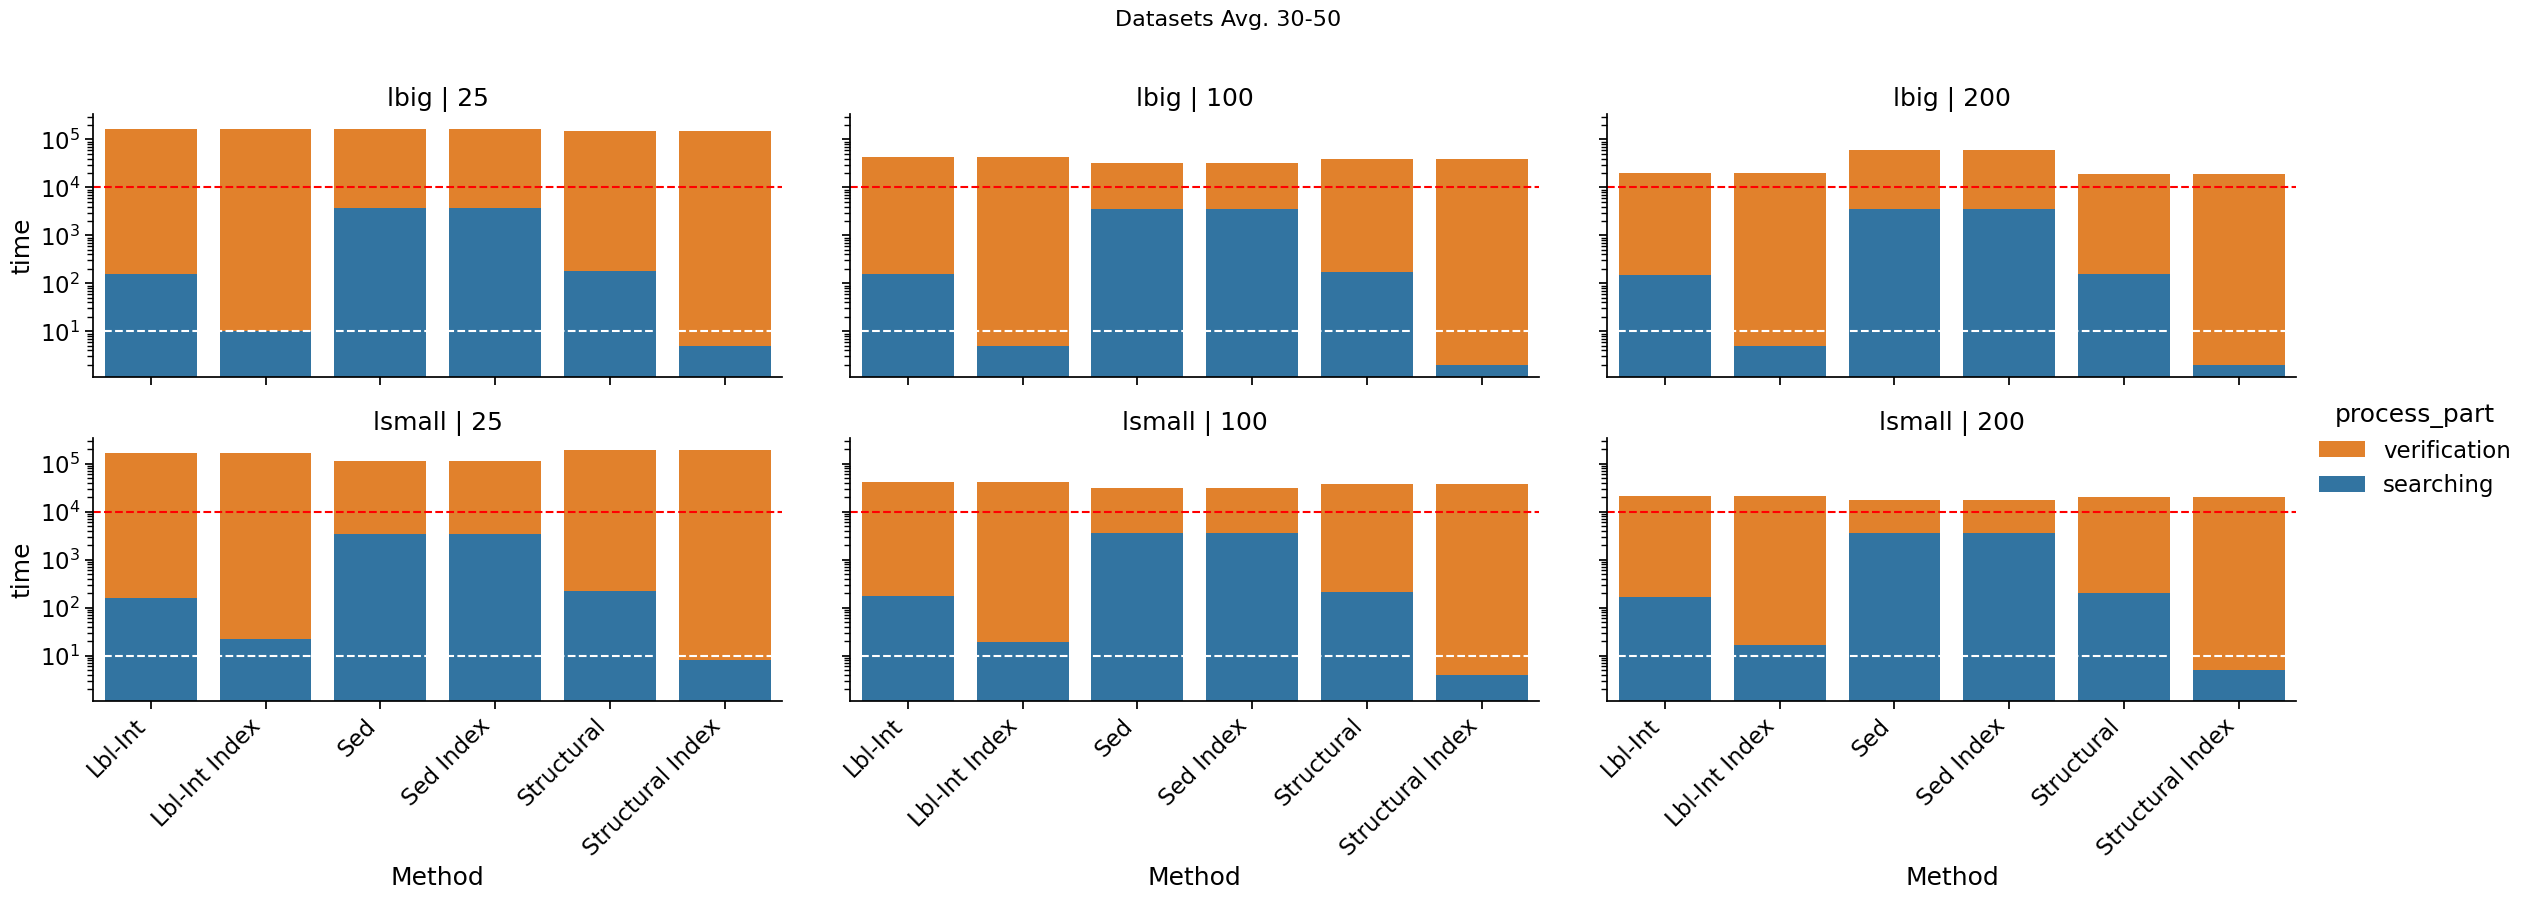

In [21]:
order = ['Lbl-Int', 'Lbl-Int Index', 'Sed', 'Sed Index', 'Structural', 'Structural Index']
# Increase overall font size
sns.set_context("notebook", font_scale=1.5)
g = sns.FacetGrid(
    alldf.sort_values('process_part', ascending=False).sort_values('Method'),
    col = 'BaseSize',
    row = 'LabelSize',
    hue = 'process_part',
    palette = hue_color_palette,
    height=4, aspect=2
    )
g = (g.map(sns.barplot, 'Method', 'time', errorbar = None, order=order).add_legend())

g.set(yscale='log')

# Increase font size for titles, labels, and ticks
g.set_titles('{row_name} | {col_name}')   # Increase font size of titles
# g.set_axis_labels('Base Size', 'Value', fontsize=28)  # Axis labels font size
axes = g.axes.flatten()
for ax in axes:
    ax.axhline(y=10_000, color='r', linestyle='--')
    ax.axhline(y=10, color='white', linestyle='--')

# Set the super title
g.fig.suptitle("Datasets Avg. 30-50", fontsize=16)

# Adjust layout to make space for the super title
g.fig.subplots_adjust(top=0.85)  # Adjust this value as needed
# Rotate x-tick labels
for ax in g.axes.flat:
    ax.set_xticklabels(order, rotation=45, ha="right")  # Rotate labels by 45 degrees


# plt.suptitle('Times for 30-50 datasets')
# g.fig.subplots_adjust(hspace=0.2, wspace=0.35)
plt.show()
sns.set_context("notebook", font_scale=1)

# Avg. distinct labels 70 - 90 per tree

In [22]:
data: PlotData = get_plot_data_ds('resources/workloads/generated-70-90')

In [23]:
display(data.statistics)

,Dataset,min_tree,max_tree,avg_tree,tree_count,avg_unique_labels_per_tree,avg_tree_distinct_labels,distinct_labels,Unnamed: 7
0,Base-25/lsmall,92,118,104.972,1000,0.105,66.982,2973,NaN
0,Base-100/lsmall,90,118,104.230,1000,0.036,66.275,2992,NaN
0,Base-200/lsmall,91,122,102.858,1000,0.006,64.708,2999,NaN
0,Base-25/lbig,88,119,104.114,1000,9.927,66.867,12541,NaN
0,Base-100/lbig,88,117,102.998,1000,8.589,66.091,14910,NaN
0,Base-200/lbig,91,117,102.890,1000,6.977,65.326,17836,NaN


In [24]:
alldf = pd.melt(data.plotdata, id_vars=['Dataset', 'Method'], value_vars=['searching', 'verification'], value_name="time")
alldf[['BaseSize', 'LabelSize']] = alldf['Dataset'].str.split('/', expand=True)
alldf[['Base', 'BaseSize']] = alldf['BaseSize'].str.split('-', expand=True)
alldf.drop('Base', axis=1, inplace=True)
alldf['BaseSize'] = alldf['BaseSize'].astype(int)

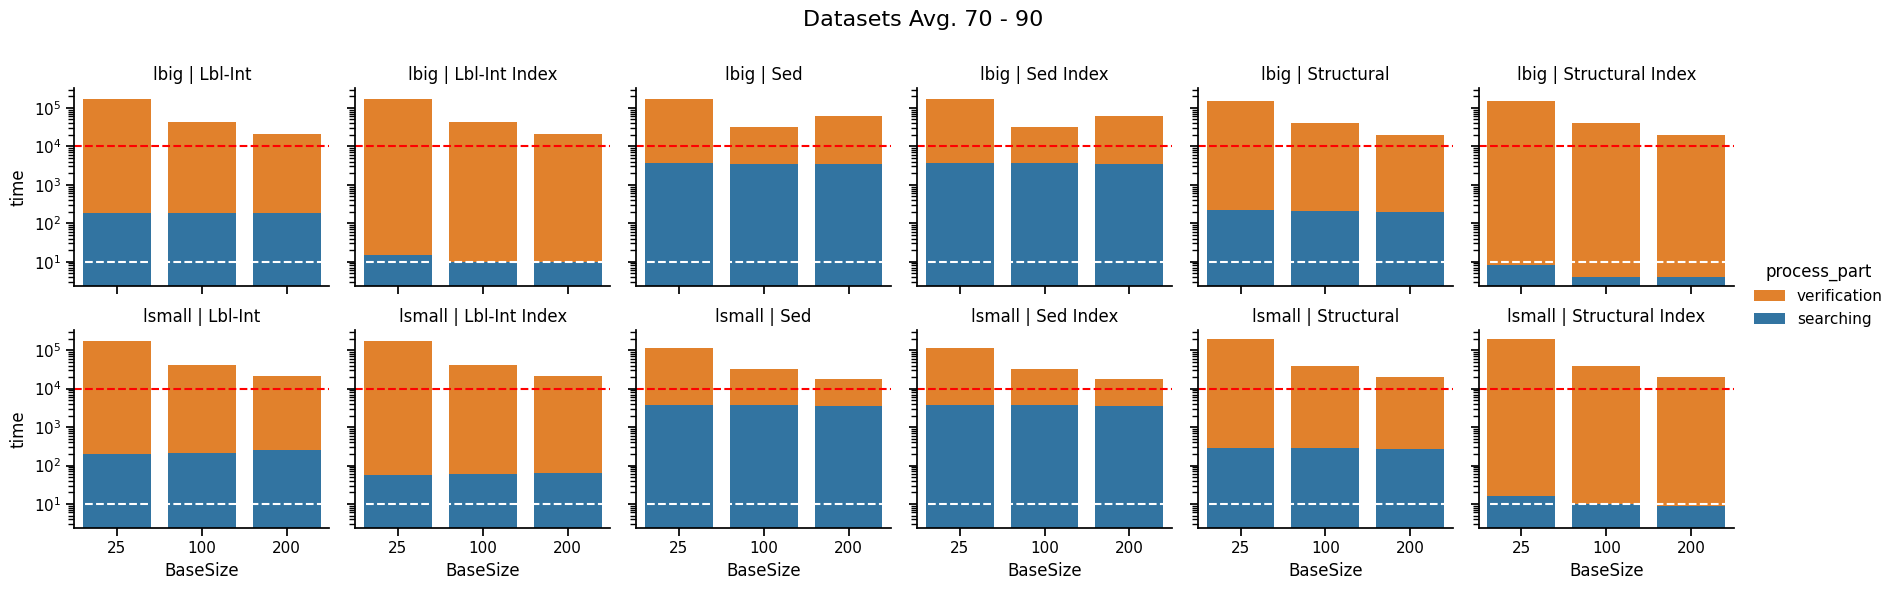

In [25]:
g = sns.FacetGrid(
    alldf.sort_values('process_part', ascending=False).sort_values('Method'),
    col = 'Method',
    row = 'LabelSize',
    hue = 'process_part',
    palette = hue_color_palette,
    )
g = (g.map(sns.barplot, 'BaseSize', 'time', errorbar = None, order=['25', '100', '200']).add_legend())

g.set(yscale='log')

# Increase font size for titles, labels, and ticks
g.set_titles('{row_name} | {col_name}')   # Increase font size of titles
# g.set_axis_labels('Base Size', 'Value', fontsize=28)  # Axis labels font size
axes = g.axes.flatten()
for ax in axes:
    ax.axhline(y=10_000, color='r', linestyle='--')
    ax.axhline(y=10, color='white', linestyle='--')

# Set the super title
g.fig.suptitle("Datasets Avg. 70 - 90", fontsize=16)

# Adjust layout to make space for the super title
g.fig.subplots_adjust(top=0.85)  # Adjust this value as needed


# plt.suptitle('Times for 30-50 datasets')
# g.fig.subplots_adjust(hspace=0.2, wspace=0.35)
plt.show()
g.savefig("Facet.png")

/tmp/ipykernel_36754/3741926853.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(order, rotation=45, ha="right")  # Rotate labels by 45 degrees
/tmp/ipykernel_36754/3741926853.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(order, rotation=45, ha="right")  # Rotate labels by 45 degrees
/tmp/ipykernel_36754/3741926853.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(order, rotation=45, ha="right")  # Rotate labels by 45 degrees
/tmp/ipykernel_36754/3741926853.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(order, rotation=45, ha="right")  # Rotate labels by 45 degr

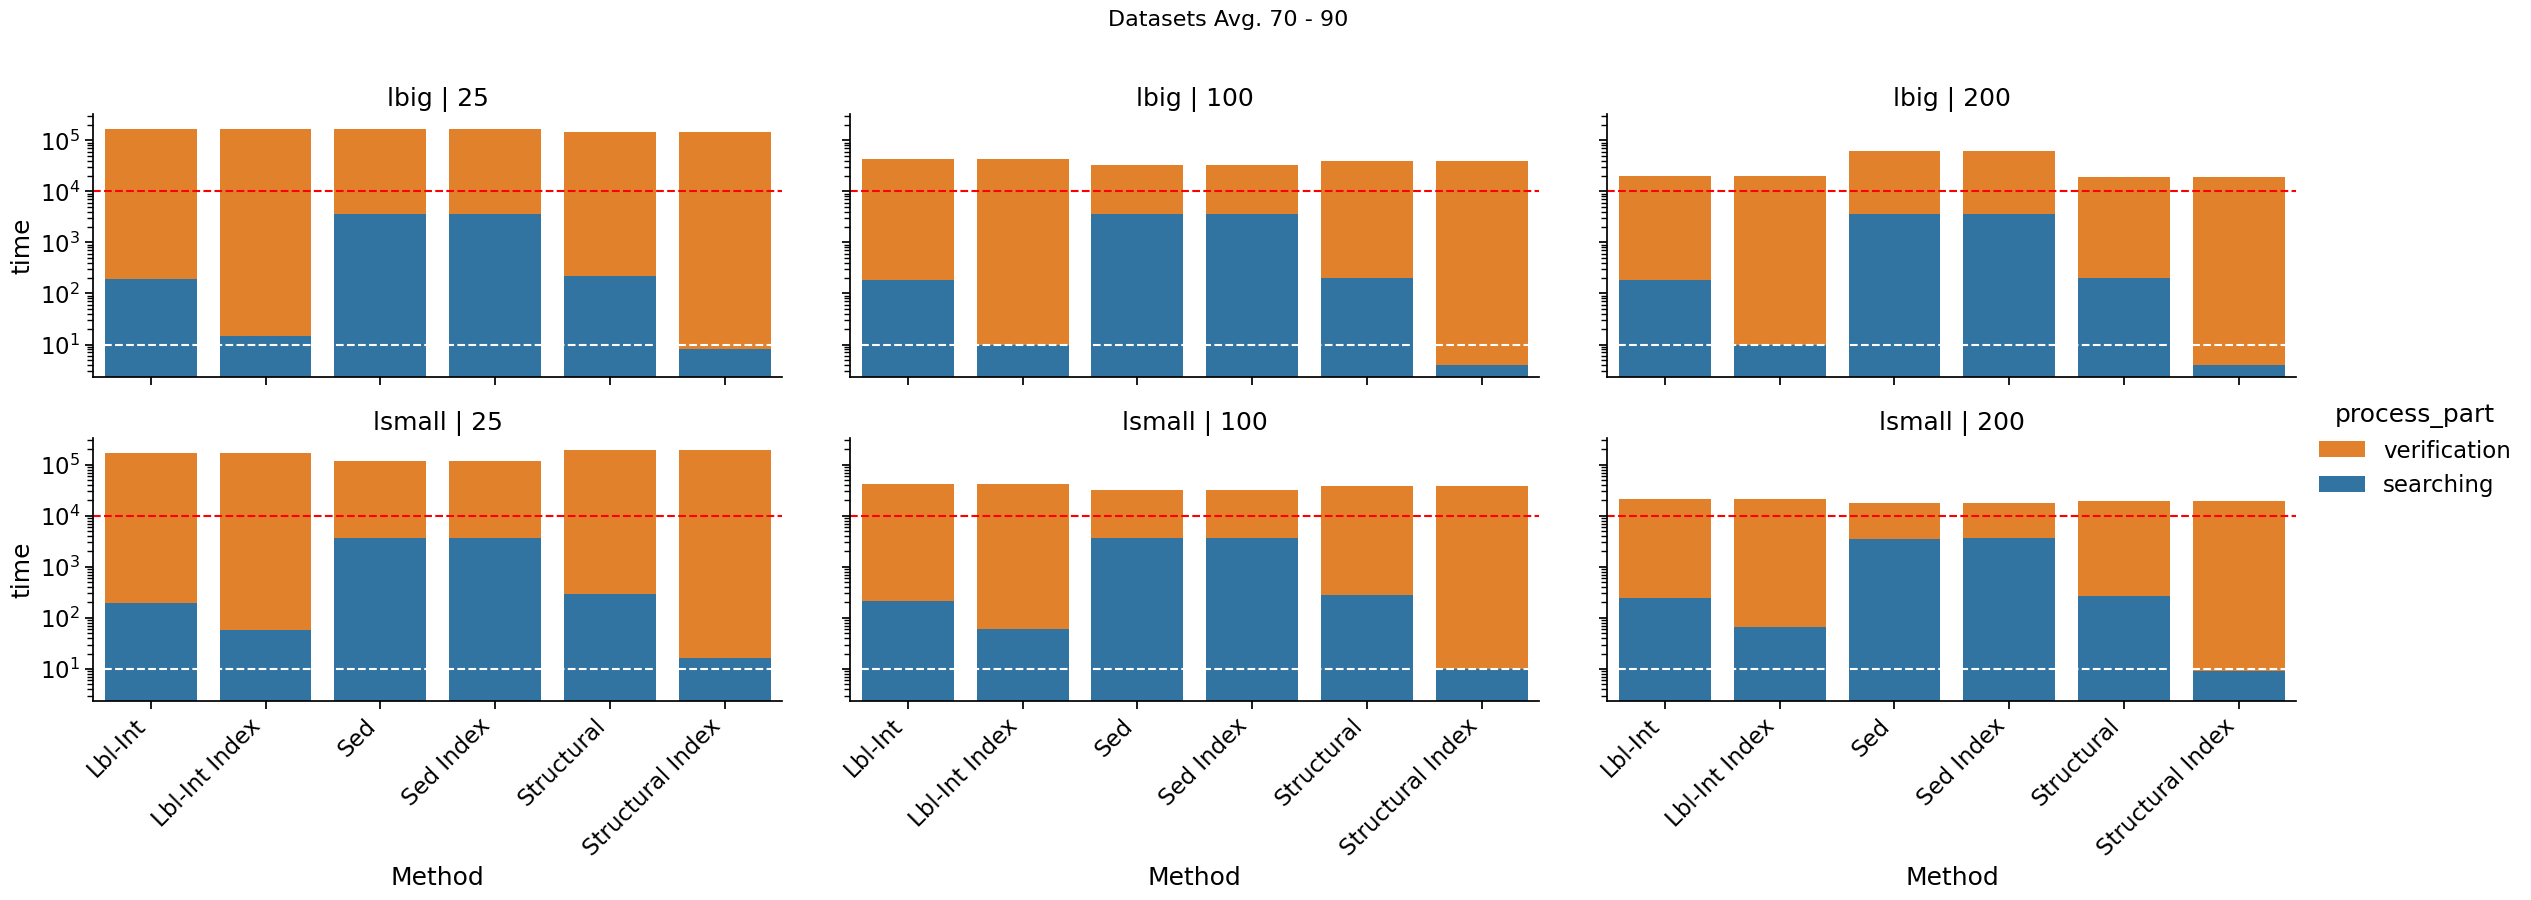

In [26]:
order = ['Lbl-Int', 'Lbl-Int Index', 'Sed', 'Sed Index', 'Structural', 'Structural Index']
# Increase overall font size
sns.set_context("notebook", font_scale=1.5)
g = sns.FacetGrid(
    alldf.sort_values('process_part', ascending=False).sort_values('Method'),
    col = 'BaseSize',
    row = 'LabelSize',
    hue = 'process_part',
    palette = hue_color_palette,
    height=4, aspect=2
    )
g = (g.map(sns.barplot, 'Method', 'time', errorbar = None, order=order).add_legend())

g.set(yscale='log')

# Increase font size for titles, labels, and ticks
g.set_titles('{row_name} | {col_name}')   # Increase font size of titles
# g.set_axis_labels('Base Size', 'Value', fontsize=28)  # Axis labels font size
axes = g.axes.flatten()
for ax in axes:
    ax.axhline(y=10_000, color='r', linestyle='--')
    ax.axhline(y=10, color='white', linestyle='--')

# Set the super title
g.fig.suptitle("Datasets Avg. 70 - 90", fontsize=16)

# Adjust layout to make space for the super title
g.fig.subplots_adjust(top=0.85)  # Adjust this value as needed
# Rotate x-tick labels
for ax in g.axes.flat:
    ax.set_xticklabels(order, rotation=45, ha="right")  # Rotate labels by 45 degrees


# plt.suptitle('Times for 30-50 datasets')
# g.fig.subplots_adjust(hspace=0.2, wspace=0.35)
plt.show()
sns.set_context("notebook", font_scale=1)